import torch 
import torch.nn as nn 
from torch.optim import SGD,lr_scheduler
from torch.utils.data import DataLoader,random_split

##torchvision
import torchvision 
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision import transforms

##other modules
import numpy as np
import os 
import copy
import time
import matplotlib.pyplot as plt 



In [1]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader
from torch.optim import SGD,lr_scheduler

## torchvision Library 
import torchvision
from torchvision import datasets,models,transforms
from torchvision.datasets import ImageFolder

##importing other library 

import numpy as np 
import time 
import os 
import copy 
import matplotlib.pyplot as plt 




In [2]:
data_dire='../data/hymenoptera_data/'
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
transform={'train':
           transforms.Compose([
               
               transforms.RandomCrop(128),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               transforms.Normalize(mean,std)
               ]),

            'val':
            transforms.Compose([
                transforms.CenterCrop(128),
                transforms.ToTensor(),
               transforms.Normalize(mean,std)
            ])
            }

In [4]:
## 
batch_size=16
dataset={x:ImageFolder(transform=transform[x],root=os.path.join(data_dire,x))
         for x in ['train','val']}


class_names=dataset['train'].classes

print('class_names :',class_names)
dataloader={x:DataLoader(dataset=dataset[x],batch_size=batch_size) 
            for x in ['train','val']}

class_names : ['ants', 'bees']


In [5]:
data_iterator_train=iter(dataloader['train'])
batch_train_images,batch_train_labels=next(data_iterator_train)

print('batch_train_images.shape :',batch_train_images.shape)

batch_train_images.shape : torch.Size([16, 3, 128, 128])


In [6]:

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


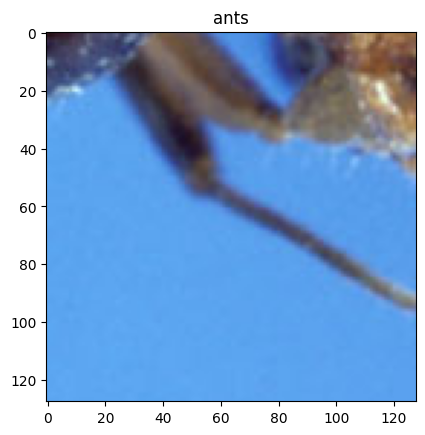

In [7]:
imshow(batch_train_images[0],class_names[batch_train_labels[0].item()])

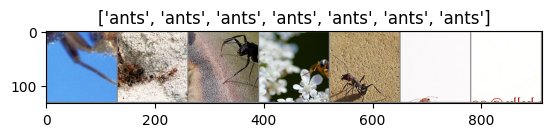

In [8]:
### printing images with torch 
out=torchvision.utils.make_grid(batch_train_images[:7],nrow=7)
imshow(out,[class_names[x] for x in batch_train_labels[:7]])

In [9]:
### preparing for training

device=('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
### loading the resnet, freezing all layer, fine_tuning the last portiionn only 

model=torchvision.models.resnet18().to(device=device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
## freezing all the parameter

for param in model.parameters():
    param.requires_grad=False

## training only model.layer4[1]
    
for param in model.layer4[1].parameters():
    param.requires_grad=True


## changing the last layer(this layer will be trained as well)

in_features=model.fc.in_features

model.fc=nn.Linear(in_features,len(class_names))


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def train_model(model,optimizer,scheduler,criterion,num_epochs=20):
    # global model
    model=model.to(device)
    start_time=time.time()
    best_wts=copy.deepcopy(model.state_dict())
    best_acc=0

    ## iterating over epochs 
    print("*************Started training*************")
    for epoch_num in range(num_epochs):
        print('Epoch Num:   ',epoch_num)
        print('--'*10)

        ##iterating over training and valid dataset 

       
        for phase in ['train','val']:

            running_loss=0.0 ## to accumulate loss in an epoch 
            running_corrects=0.0


            if phase=='train':
                model.train()

            else:
                model.eval()

            for images,labels in dataloader[phase]:
                images=images.to(device=device)
                labels=labels.to(device=device)

                with torch.set_grad_enabled(phase=='train'):
                    pred=model(images)
                    loss=criterion(pred,labels)
                    pred_class=torch.argmax(pred,1)

                    ###updating if only train

                    if phase=='train':
                        optimizer.step()
                        optimizer.zero_grad()

                ##calculating loss 
                        
                running_loss+=loss.item()*images.shape[0] ## converting avg_loss to total loss
                
                running_corrects+=torch.sum((labels==pred_class).to(dtype=torch.float32))



            if phase=='train':
                scheduler.step()

            epoch_loss=running_loss/len(dataset[phase])
            epoch_acc=running_corrects.double()/len(dataset[phase])

            print("{} | Acc: {:.2f}   Loss: {:.2f}".format(phase,epoch_acc,epoch_loss))

            ##updating weights if val_acc>>train_accuracy
            if phase=="val" and epoch_acc>best_acc:
                best_wts=copy.deepcopy(model.state_dict())
                best_acc=epoch_acc

            print()
    
    time_elapsed=time.time()-start_time

    print('Training Completed in {:.3f} seconds'.format(time_elapsed))

    print('Best Accuracy: {:.2f}'.format(best_acc))

     # load best model weights
    model.load_state_dict(best_wts)
    return model

            

                

        

In [14]:
opt=SGD(model.parameters(),lr=0.01)
step_lr=lr_scheduler.StepLR(optimizer=opt,step_size=7,gamma=0.1)


In [15]:
criterion=nn.CrossEntropyLoss().to(device)

In [16]:
model=train_model(model=model,
                  optimizer=opt,
                  scheduler=step_lr,
                  criterion=criterion)

*************Started training*************
Epoch Num:    0
--------------------
train | Acc: 0.49   Loss: 0.71

val | Acc: 0.61   Loss: 0.68

Epoch Num:    1
--------------------
train | Acc: 0.50   Loss: 0.71

val | Acc: 0.59   Loss: 0.68

Epoch Num:    2
--------------------
train | Acc: 0.48   Loss: 0.71

val | Acc: 0.59   Loss: 0.68

Epoch Num:    3
--------------------
train | Acc: 0.50   Loss: 0.71

val | Acc: 0.59   Loss: 0.68

Epoch Num:    4
--------------------
train | Acc: 0.50   Loss: 0.71

val | Acc: 0.58   Loss: 0.68

Epoch Num:    5
--------------------
train | Acc: 0.49   Loss: 0.71

val | Acc: 0.56   Loss: 0.68

Epoch Num:    6
--------------------
train | Acc: 0.50   Loss: 0.72

val | Acc: 0.56   Loss: 0.68

Epoch Num:    7
--------------------
train | Acc: 0.51   Loss: 0.71

val | Acc: 0.58   Loss: 0.68

Epoch Num:    8
--------------------
train | Acc: 0.50   Loss: 0.71

val | Acc: 0.58   Loss: 0.69

Epoch Num:    9
--------------------
train | Acc: 0.49   Loss: 0.7

In [35]:
from PIL import Image 

In [36]:
test_img_path='/mnt/f/pytorch-101/data/hymenoptera_data/train/ants/7759525_1363d24e88.jpg'
test_img=Image.open(test_img_path)

In [47]:
## predict label from the img_dire

def inference(img_dire,gt_class):
    pil_img=Image.open(img_dire)
    img=transform['val'](pil_img).unsqueeze(0).to(device)
    pred_label=torch.argmax(model(img),1).item()
    pred_class=class_names[pred_label]
    plt.imshow(pil_img)
    plt.title(f'Ground Truth Label: {gt_class} | Predicted Label : {pred_class}')
    
    

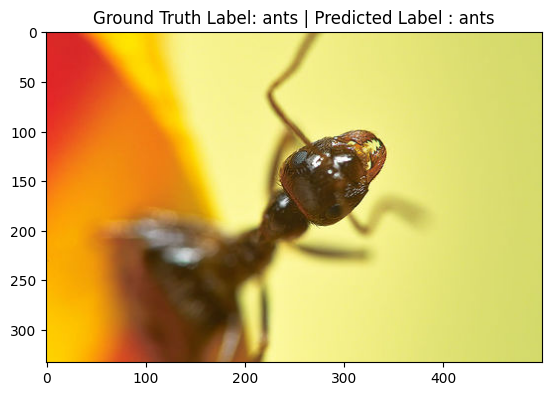

In [49]:
inference(test_img_path,'ants')

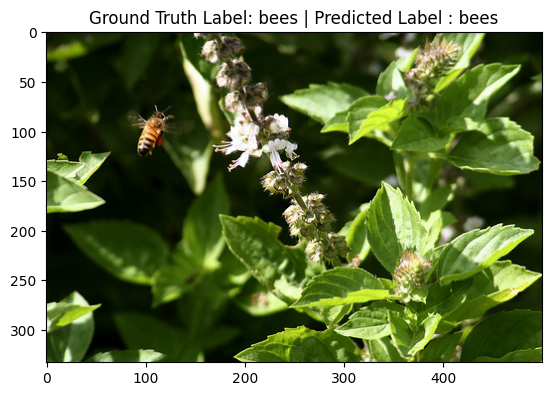

In [50]:
inference('/mnt/f/pytorch-101/data/hymenoptera_data/train/bees/95238259_98470c5b10.jpg','bees')